In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import pyedflib
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, MaxPooling1D
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
# files to read => chb01_03.edf, chb01_04.edf, chb01_15.edf,  chb01_16.edf,  chb01_18.edf,  chb01_21.edf,  chb01_26.edf,  chb02_16.edf, chb02_19.edf, chb03_01.edf, chb03_02.edf, chb03_03.edf, chb03_04.edf
files_to_read = [
        'chb01_03.edf',
        'chb01_04.edf',
        'chb01_15.edf',
        'chb01_16.edf',
        'chb01_18.edf',
        'chb01_21.edf',
        'chb01_26.edf',
        'chb02_16.edf',
        'chb02_19.edf',
        'chb03_01.edf',
        'chb03_02.edf',
        'chb03_03.edf',
        'chb03_04.edf',
        'chb04_05.edf',
        'chb04_28.edf',
        'chb05_06.edf',
        'chb05_13.edf',
        'chb05_16.edf',
        'chb05_17.edf',
        'chb05_22.edf',
        'chb06_04.edf',
        'chb06_09.edf',
        'chb06_10.edf',
        'chb06_13.edf',
        'chb06_18.edf',
        'chb06_24.edf',
        'chb07_12.edf',
        'chb07_13.edf',
        'chb07_19.edf',
        'chb08_02.edf',
        'chb08_05.edf',
        'chb08_11.edf',
        'chb08_13.edf',
        'chb08_21.edf',
        'chb09_06.edf',
        'chb09_08.edf',
        'chb09_19.edf',
        'chb10_12.edf',
        'chb10_20.edf',
        'chb10_27.edf',
        'chb10_30.edf',
        'chb10_31.edf',
        'chb10_38.edf',
        'chb10_89.edf',
        ]
seizure_seconds_each_file_start_and_end_seconds = [
        ('chb01_03.edf',2996, 3036),
        ('chb01_04.edf', 1467, 1494),
        ('chb01_15.edf', 1732, 1772),
        ('chb01_16.edf',1015, 1066),
        ('chb01_18.edf', 1720, 1810),
        ('chb01_21.edf', 327, 420),
        ('chb01_26.edf', 1862, 1963),
        ('chb02_16.edf', 130, 212),
        ('chb02_19.edf', 2972, 3053),
        ('chb03_01.edf', 362, 414),
        ('chb03_02.edf', 731, 796),
        ('chb03_03.edf', 432, 501),
        ('chb03_04.edf', 2162, 2214),
        ('chb04_05.edf', 7804, 7853),
        ('chb04_28.edf', 1679, 1781),
        ('chb04_28.edf', 3782, 3898),
        ('chb05_06.edf', 417, 532),
        ('chb05_13.edf', 1086, 1196),
        ('chb05_16.edf', 2317, 2413),
        ('chb05_17.edf', 2451, 2571),
        ('chb05_22.edf', 2348, 2465),
        ('chb06_04.edf', 327, 347),
        ('chb06_04.edf', 6211, 6231),
        ('chb06_09.edf', 12500, 12516),
        ('chb06_10.edf', 10833, 10845),
        ('chb06_13.edf', 506, 519),
        ('chb06_18.edf', 7799, 7811),
        ('chb06_24.edf', 9387, 9403),
        ('chb07_12.edf', 4920, 5006),
        ('chb07_13.edf', 3285, 3381),
        ('chb07_19.edf', 13688, 13831),
        ('chb08_02.edf', 2670, 2841),
        ('chb08_05.edf', 2856, 3046),
        ('chb08_11.edf', 2988, 3122),
        ('chb08_13.edf', 2417, 2577),
        ('chb08_21.edf', 2083, 2347),
        ('chb09_06.edf', 12231, 12295),
        ('chb09_08.edf', 2951, 3030),
        ('chb09_08.edf', 9196, 9267),
        ('chb09_19.edf', 5299, 5361),
        ('chb10_12.edf', 6313, 6348),
        ('chb10_20.edf', 6888, 6958),
        ('chb10_27.edf', 2382, 2447),
        ('chb10_30.edf', 3021, 3079),
        ('chb10_31.edf', 3801, 3877),
        ('chb10_38.edf', 4618, 4707),
        ('chb10_89.edf', 1383, 1437),
        ]
signals = []

for file in files_to_read:
        f = pyedflib.EdfReader(file)
        n = f.signals_in_file
        signal_labels = f.getSignalLabels()
        fz_cz_index = signal_labels.index('FZ-CZ')
        cz_pz_index = signal_labels.index('CZ-PZ')
        sigbufs = np.zeros((2, f.getNSamples()[0]))
        sigbufs[0] = f.readSignal(fz_cz_index)
        sigbufs[1] = f.readSignal(cz_pz_index)
        signals.append(np.array(sigbufs))
        f.close()
len(signals)

44

In [3]:
#delete the first 5 percent and last 5 percent of the signal
for i in range(len(signals)):
    signals[i] = signals[i][:,int(0.05*len(signals[i][0])):int(0.95*len(signals[i][0]))]

In [4]:
signals[0].shape

(2, 829440)

In [4]:
shorted_signals = signals[0:20]

In [6]:
#split each signal into 20 * 256 second windows
window_size = 20 * 256
windowed_signals = np.zeros((0, 2, window_size))
y_labels = []
index = 0
for signal in shorted_signals:
    try:
        print(index)
        start_time = seizure_seconds_each_file_start_and_end_seconds[index][1]*256
        end_time = seizure_seconds_each_file_start_and_end_seconds[index][2]*256
        for i in range(0, signal.shape[1], window_size):
            windowed_signals = np.append(windowed_signals, np.array([signal[:, i:i+window_size]]), axis=0)
            #if i and i+window_size contains seizure time, then label it as 1, otherwise 0
            if i in range(start_time, end_time) or i+window_size in range(start_time, end_time):
                y_labels.append(1)
            else:
                y_labels.append(0)
        index += 1
    except:
        print("error in file: ")
        print(index)
        index += 1
        continue
    

0
1
2
3
4
5
6
error in file: 
6
7
error in file: 
7
8
9
10
11
12
13
error in file: 
13
14
error in file: 
14
15
16
17
18
19


In [7]:
print(len(windowed_signals), len(y_labels))

4240 4240


In [8]:
sum(y_labels)

90

In [9]:
windowed_signals.shape

(4240, 2, 5120)

In [5]:
#loop only in seizure time

window_size = 5 * 256
seizure_data_signals = np.zeros((0, 2, window_size))
seizure_data_y_labels = []

for i in range(len(signals)):
    try:
        print(i)
        start_time = seizure_seconds_each_file_start_and_end_seconds[i][1]*256
        end_time = seizure_seconds_each_file_start_and_end_seconds[i][2]*256
        for j in range(start_time, end_time, 256):
            seizure_data_signals = np.append(seizure_data_signals, np.array([signals[i][:, j:j+window_size]]), axis=0)
            seizure_data_y_labels.append(1)
    except:
        print("error in file: ")
        print(i)
        continue

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
error in file: 
15
16
17
18
19
20
21
22
23
24
error in file: 
24
25
26
27
error in file: 
27
28
29
error in file: 
29
30
error in file: 
30
31
32
33
34
35
36
error in file: 
36
37
38
error in file: 
38
39
40
41
error in file: 
41
42
43


In [6]:
len(seizure_data_y_labels)

2937

In [85]:
#loop only in non-seizure time and get 10000 random windows

window_size = 5 * 256
non_seizure_data_signals = np.zeros((0, 2, window_size))
non_seizure_data_y_labels = []

for i in range(len(signals)):
    print(i)
    start_time = seizure_seconds_each_file_start_and_end_seconds[i][1]*256
    end_time = seizure_seconds_each_file_start_and_end_seconds[i][2]*256
    #a integer random jump between 0 and 50
    random_jumps = np.random.randint(1, 50)
    for j in range(0, signals[i].shape[1], random_jumps*256):
        random_jumps = np.random.randint(1, 50)
        if j in range(start_time, end_time) or j+window_size in range(start_time, end_time):
            continue
        else:
            if j + window_size > signals[i].shape[1]:
                break
            non_seizure_data_signals = np.append(non_seizure_data_signals, np.array([signals[i][:, j:j+window_size]]), axis=0)
            non_seizure_data_y_labels.append(0)
    if len(non_seizure_data_y_labels) > 10000:
        break
len(non_seizure_data_y_labels)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


10083

In [86]:
len(non_seizure_data_y_labels)

10083

In [87]:
final_signals = np.append(seizure_data_signals, non_seizure_data_signals, axis=0)
final_y_labels = np.append(seizure_data_y_labels, non_seizure_data_y_labels, axis=0)

In [88]:
print(final_signals.shape, final_y_labels.shape)

(13020, 2, 1280) (13020,)


In [89]:
#normalize the signals with MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
final_signals = scaler.fit_transform(final_signals.reshape(-1, 2*window_size)).reshape(-1, 2, window_size)
final_signals.shape

(13020, 2, 1280)

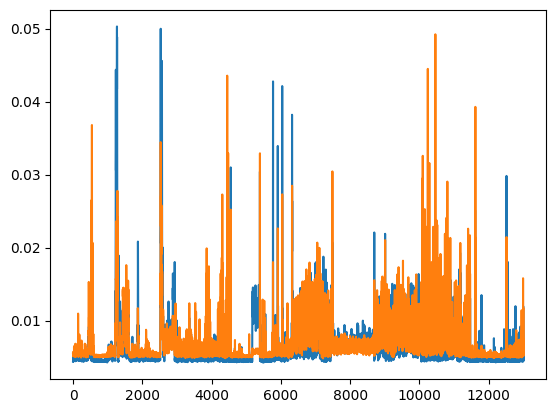

In [90]:
var = np.var(final_signals, axis=2)
plt.plot(var)

In [93]:
fft = np.fft.fft(final_signals, axis=2)
fft.shape

(13020, 2, 1280)

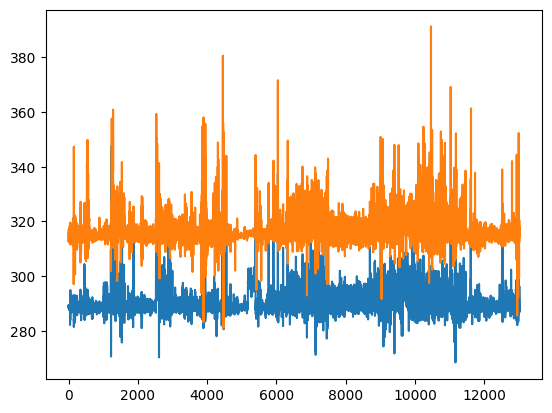

In [94]:
fft_var = np.var(fft, axis=2)
plt.plot(fft_var)

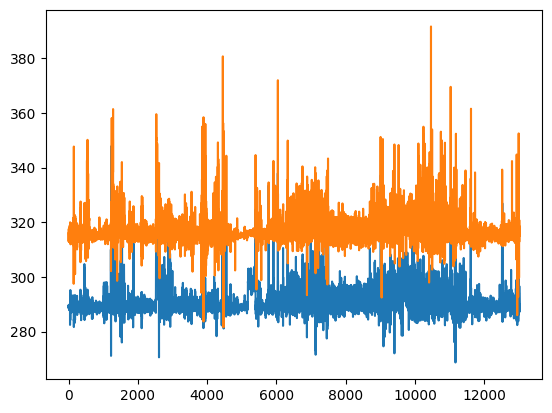

In [95]:
energy = np.sum(np.square(final_signals), axis=2)
plt.plot(energy)

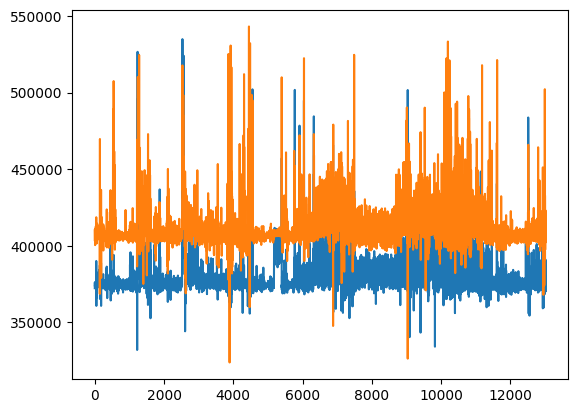

In [99]:
#complexity
complexity = np.sum(np.square(np.abs(np.diff(fft, axis=2))), axis=2)
plt.plot(complexity)

In [104]:
features = np.concatenate((var, fft_var, energy, complexity), axis=1)
features.shape

(13020, 8)

In [107]:
#random forest classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


X_train, X_test, y_train, y_test = train_test_split(features, final_y_labels, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.772273425499232


In [109]:
#random forest classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#use just one channel of the signals
final_signals_one_channel = final_signals[:, 0, :]

X_train, X_test, y_train, y_test = train_test_split(final_signals_one_channel, final_y_labels, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.7695852534562212


In [110]:
#split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(final_signals, final_y_labels, random_state=42)

In [111]:
X_train.shape

(9765, 2, 1280)

In [112]:
#one hot encode target column
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

In [113]:
#now lets make the model
model = Sequential()
model.add(Conv1D(filters=256, kernel_size=10, activation='relu', input_shape=(1280, 2)))
model.add(MaxPooling1D(pool_size=2))
# model.add(Dropout(0.3))
model.add(Conv1D(filters=128, kernel_size=10, activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Dropout(0.3))
model.add(Conv1D(filters=128, kernel_size=10, activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.summary()

model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 1271, 256)         5376      
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 635, 256)         0         
 g1D)                                                            
                                                                 
 conv1d_13 (Conv1D)          (None, 626, 128)          327808    
                                                                 
 conv1d_14 (Conv1D)          (None, 617, 128)          163968    
                                                                 
 flatten_4 (Flatten)         (None, 78976)             0         
                                                                 
 dense_8 (Dense)             (None, 50)                3948850   
                                                      

In [114]:
X_train = X_train.reshape(X_train.shape[0], 1280, 2)
X_test = X_test.reshape(X_test.shape[0], 1280, 2)

In [115]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train.shape

(9765, 1280, 2)

In [116]:
X_train.shape

(9765, 1280, 2)

In [117]:
model.fit(
    X_train,
    y_train_categorical,
    epochs=10,
    shuffle=True,
    verbose=2
)

Epoch 1/10
306/306 - 208s - loss: 0.5470 - accuracy: 0.7748 - 208s/epoch - 680ms/step
Epoch 2/10
306/306 - 182s - loss: 0.5368 - accuracy: 0.7760 - 182s/epoch - 595ms/step
Epoch 3/10
306/306 - 200s - loss: 0.5332 - accuracy: 0.7759 - 200s/epoch - 653ms/step
Epoch 4/10
306/306 - 192s - loss: 0.5312 - accuracy: 0.7782 - 192s/epoch - 626ms/step
Epoch 5/10
306/306 - 211s - loss: 0.5274 - accuracy: 0.7806 - 211s/epoch - 691ms/step
Epoch 6/10
306/306 - 200s - loss: 0.5258 - accuracy: 0.7804 - 200s/epoch - 654ms/step
Epoch 7/10
306/306 - 195s - loss: 0.5237 - accuracy: 0.7808 - 195s/epoch - 639ms/step
Epoch 8/10
306/306 - 195s - loss: 0.5373 - accuracy: 0.7764 - 195s/epoch - 637ms/step
Epoch 9/10
306/306 - 192s - loss: 0.5262 - accuracy: 0.7805 - 192s/epoch - 629ms/step
Epoch 10/10
306/306 - 183s - loss: 0.5212 - accuracy: 0.7819 - 183s/epoch - 597ms/step


In [118]:
#evaluate the model
model_loss, model_accuracy = model.evaluate(
    X_test, y_test_categorical, verbose=2)
print(
    f"Normal Neural Network - Loss: {model_loss}, Accuracy: {model_accuracy}")

102/102 - 10s - loss: 0.5449 - accuracy: 0.7724 - 10s/epoch - 102ms/step
Normal Neural Network - Loss: 0.544857382774353, Accuracy: 0.7723502516746521


In [119]:
#model recall and f1 score and precision
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test_categorical, axis=1)
print(classification_report(y_test, y_pred))

102/102 [==============================] - 13s 126ms/step
              precision    recall  f1-score   support

           0       0.77      1.00      0.87      2505
           1       0.68      0.02      0.04       750

    accuracy                           0.77      3255
   macro avg       0.73      0.51      0.46      3255
weighted avg       0.75      0.77      0.68      3255



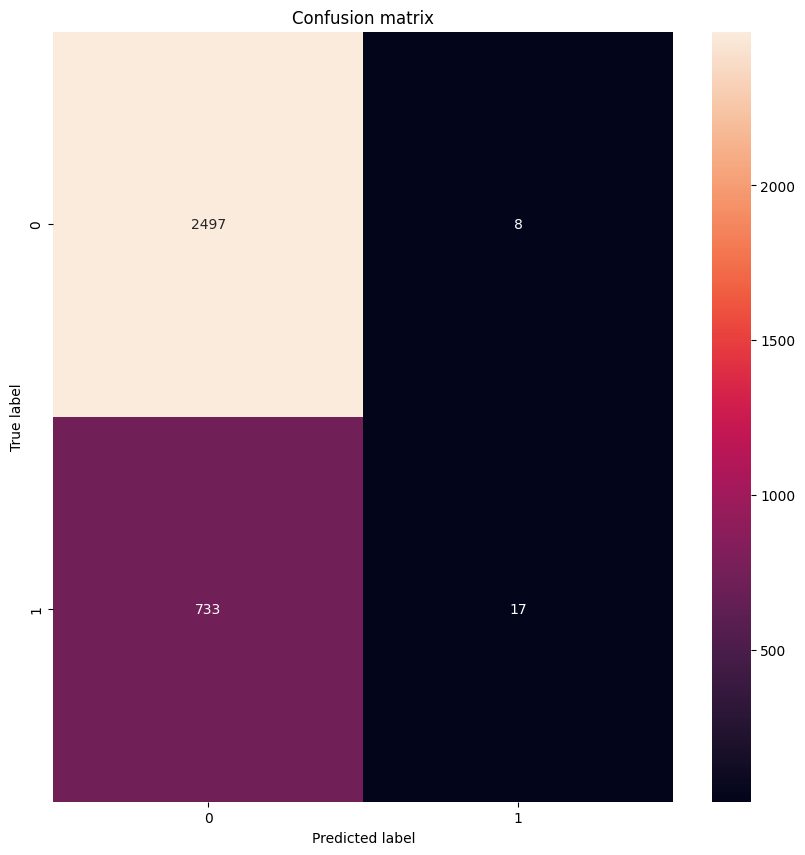

In [120]:
#plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [121]:
#false alarm rate
false_alarm_rate = cm[0][1]/(cm[0][1]+cm[1][1])
print("false alarm rate: ", false_alarm_rate)

#missed detection rate
missed_detection_rate = cm[1][0]/(cm[1][0]+cm[0][0])
print("missed detection rate: ", missed_detection_rate)

false alarm rate:  0.32
missed detection rate:  0.22693498452012384


In [ ]:
model.save("model1.h5")